# Autoencoder test

Testing the trained autoencoders:

In [10]:
import os
import random

import cv2
#import imgaug
import numpy as np
import torch as th

from autoencoder import load_ae, preprocess_image
#from ae.data_loader import CheckFliplrPostProcessor, get_image_augmenter

args_folder = "./data_generated_track"
args_ae_path = "ae-32_1.pkl"
args_augment = False
args_seed = None

if args_seed is not None:
    random.seed(args_seed)
    np.random.seed(args_seed)
    th.manual_seed(args_seed)
    if th.cuda.is_available():
        th.backends.cudnn.deterministic = True
        th.backends.cudnn.benchmark = False


if not args_folder.endswith("/"):
    args_folder += "/"

autoencoder = load_ae(args_ae_path)
autoencoder2 = load_ae("ae-32_100k.pkl")
autoencoder3 = load_ae("ae-64_5k_best.pkl")
aut = [autoencoder, autoencoder2, autoencoder3]

images = [im for im in os.listdir(args_folder) if im.endswith(".jpg")]
images = np.array(images)
n_samples = len(images)

Dim AE = 32
PyTorch 2.2.1+cu121
Dim AE = 32
PyTorch 2.2.1+cu121
Dim AE = 64
PyTorch 2.2.1+cu121


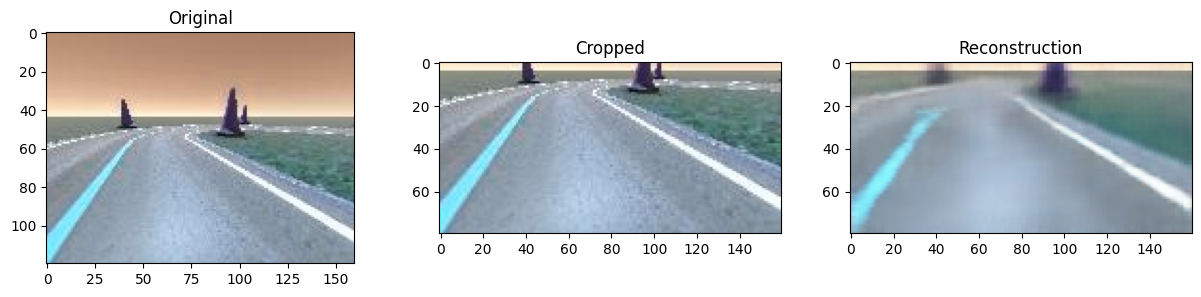

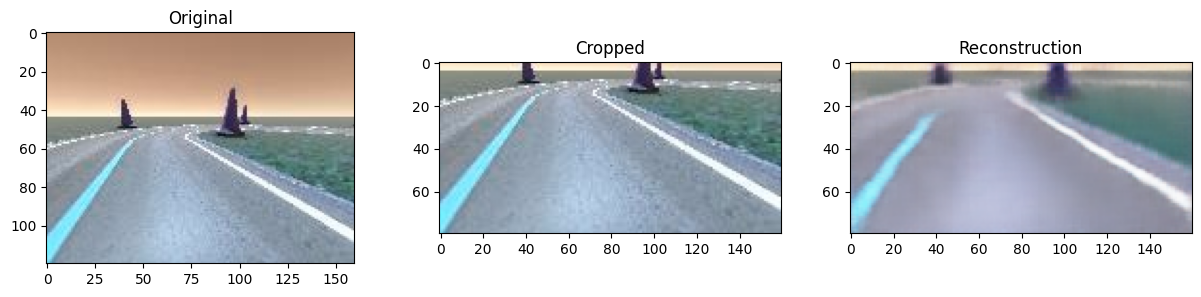

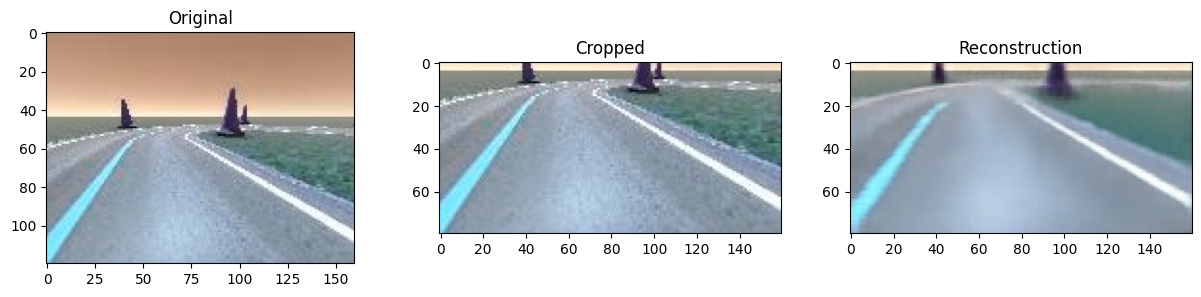

In [15]:
from matplotlib import pyplot as plt
# Load test image
image_idx = np.random.randint(n_samples)
image_path = args_folder + images[image_idx]
image = cv2.imread(image_path)

# postprocessor = CheckFliplrPostProcessor()

input_image = image

# if postprocessor.flipped:
#     print("entra")
#     #image = imgaug.augmenters.Fliplr(1).augment_image(image)

cropped_image = preprocess_image(image, convert_to_rgb=False, normalize=False)
for autoenc in aut:
    encoded = autoenc.encode_from_raw_image(input_image)
    reconstructed_image = autoenc.decode(encoded)[0]

    error = np.mean((cropped_image - reconstructed_image) ** 2)

    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15, 3))
    ax1.imshow(image)
    ax1.set_title("Original")
    ax2.imshow(cropped_image)
    ax2.set_title("Cropped")
    ax3.imshow(reconstructed_image)
    ax3.set_title("Reconstruction")

    # if augmenter is not None:
    #     plt.imshow("Augmented", input_image)

# Cleaning the images gathered testing

In [ ]:
from numpy.linalg import norm
from tqdm import tqdm

def get_similarity(emb1, img_path2):
    #img1 = cv2.imread(img_path1)
    img2 = cv2.imread(img_path2)    
    #emb1 = (autoencoder.encode_from_raw_image(img1))[0]
    emb2 = (autoencoder.encode_from_raw_image(img2))[0]
    # compute cosine similarity
    cosine = np.dot(emb1,emb2)/(norm(emb1)*norm(emb2))
    if cosine > 0.8:
        plt.imshow(img2)
        plt.show()
        print(cosine)
        os.remove(img_path2)

images_test = [im for im in os.listdir("./test_images/") if im.endswith(".jpg")]
images_test = np.array(images_test)

image_path = "./test_images/84811.jpg"
plt.imshow(cv2.imread(image_path))
plt.show()
# get_similarity(image_path, "./test_images/83042.jpg")
# get_similarity(image_path, "./test_images/83443.jpg")
img = cv2.imread(image_path)
emb = (autoencoder.encode_from_raw_image(img))[0]

for im in tqdm(images_test):
    get_similarity(emb, "./test_images/"+im)

# Line detection tests

In [ ]:
image_path = args_folder + images[15]
image = cv2.imread(image_path)
plt.imshow(image)

In [ ]:
#https://medium.com/@vipinra79/a-guide-to-edge-detection-and-line-detection-in-computer-vision-using-opencv-dba499b5b4b3
import cv2
import os
import numpy as np
from skimage import morphology

def img_line_intersection(x1,y1,x2,y2):
    XLIM = 160
    YLIM = 120
    # y = mx + c
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - (slope * x1)
    x11 = 0
    y11 = slope*x11 + intercept
    if y11 < 0:
        y11 = 0
        x11 = -intercept/slope
    if y11 > YLIM:
        y11 = YLIM
        x11 = (YLIM-intercept)/slope

    x22 = XLIM
    y22 = slope*x22 + intercept
    if y22 < 0:
        y22 = 0
        x22 = -intercept/slope
    if y22 > YLIM:
        y22 = YLIM
        x22 = (YLIM-intercept)/slope
        
    return round(x11), round(y11), round(x22), round(y22)



class Line():
    def __init__(self,x1,y1,x2,y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
    
    def __repr__(self):
        return self.__str__()
    def __str__(self):
        return f"(x1,y1) {(self.x1,self.y1)}  (x2,y2) {(self.x2,self.y2)}"

def dist(l1, l2):
    return (l1.x1-l2.x1)**2+(l1.y1-l2.y1)**2
    
def merge_xy(xy):
    return
    # prev_line = xy[0]
    # res = []
    # aux = [prev_line]
    # for it, line in enumerate(xy):
    #     if it != 0:
    #         if dist(line,prev_line) < 4:
    #             aux.append(line)
    #         else:
    #             res.append(avg(aux))
    #             aux = [line]
    #         prev_line = line
        

def detect_lines(image):    
    # Grayscale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = 220
    maxval = 255
    im_bin = np.uint8((gray > thresh) * maxval)
    im_bin[:50,:] = 0
    
    ima_open = np.maximum(morphology.opening(im_bin,np.ones((1,2))),morphology.opening(im_bin,np.ones((2,1))))
    
    # Canny edge detection
    edges = cv2.Canny(ima_open, 0, 255, apertureSize=5)
    
    # Hough Line Transform
    lines = cv2.HoughLines(edges, 1.5, np.pi / 180, 60)

    xy = []
    for line in lines:
        rho, theta = line[0]
        # Convert polar coordinates to Cartesian coordinates
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        x1,y1,x2,y2 = img_line_intersection(x1,y1,x2,y2)
        xy.append(Line(x1,y1,x2,y2))
        print(f"(x1,y1) {(x1,y1)}  (x2,y2) {(x2,y2)}")
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 1)
    
    xy.sort(key=lambda p: p.x1)
    print(xy)
    merge_xy(xy)
    xy.sort(key=lambda p: p.x2)
    xy.sort(key=lambda p: p.y1)
    xy.sort(key=lambda p: p.y2)
    
    # rhth = []
    # for line in lines:
    #     rho, theta = line[0]
    #     rhth.append((rho,theta))
    # rhth.sort()

    # def sum_pair(lst):
    #     aux1=aux2=0
    #     le = len(lst)
    #     for pair in lst:
    #         aux1+=pair[0]
    #         aux2+=pair[1]
    #     return(aux1/le,aux2/le)

    # def summarise(rhth):
    #     prev = rhth[0]
    #     act = []
    #     res = []
    #     for pair in rhth:
    #         if ((pair[0]-prev[0]<3) and (pair[1]-prev[1]<0.05)) or ((pair[0]-prev[0]<3) and (pair[1]-prev[1]<0.05)):
    #             act.append(pair)
    #         else:
    #             res.append(sum_pair(act))
    #             act = [pair]
    #         prev=pair
    #     res.append(sum_pair(act))
    #     return res

    # res = summarise(rhth)
    # res.sort()
    # res = summarise(res)
    # res.sort()
    # res = summarise(res)
    # res.sort()
    # res = summarise(res)
    # res.sort()
    # res = summarise(res)
    # print(res)

    # for (rho, theta) in res:
    #     # Convert polar coordinates to Cartesian coordinates
    #     a = np.cos(theta)
    #     b = np.sin(theta)
    #     x0 = a * rho
    #     y0 = b * rho
    #     x1 = int(x0 + 1000 * (-b))
    #     y1 = int(y0 + 1000 * (a))
    #     x2 = int(x0 - 1000 * (-b))
    #     y2 = int(y0 - 1000 * (a))

    #     # Draw lines on the original image
    #     slope = (y2 - y1) / (x2 - x1)
    #     # calculating intercept of a line
    #     intercept = y1 - (slope * x1)
    #     cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 1)
    plt.imshow(image)

In [ ]:
image_path = args_folder + images[1920]
image = cv2.imread(image_path)
detect_lines(image)